In [ ]:
!pip install lightgbm xgboost

In [ ]:
from ast import literal_eval
import os, json, time, zipfile, re
import warnings, gc, sys
from IPython.display import display

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (ExtraTreesClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix, f1_score,
                             make_scorer, precision_score, recall_score,
                             roc_auc_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import xgboost as xgb

warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)

%matplotlib inline

# Models for predicting ESG ratings

In [ ]:
features_data = pd.read_csv('features_data_train.csv', index_col=0)

features_data['ESG_Rank'] = np.where(features_data['ESG_Rank'] == '144-145', '144', features_data['ESG_Rank'])
features_data['ESG_Rank'] = np.where(features_data['ESG_Rank'] == '157-160', '157', features_data['ESG_Rank'])
features_data['E_Rank'] = np.where(features_data['E_Rank'] == '126-127', '126', features_data['E_Rank'])
features_data['E_Rank'] = np.where(features_data['E_Rank'] == '133-134', '133', features_data['E_Rank'])
features_data['E_Rank'] = np.where(features_data['E_Rank'] == '145-146', '145', features_data['E_Rank'])
features_data['E_Rank'] = np.where(features_data['E_Rank'] == '157-160', '157', features_data['E_Rank'])
features_data['S_Rank'] = np.where(features_data['S_Rank'] == '157-160', '157', features_data['S_Rank'])
features_data['G_Rank'] = np.where(features_data['G_Rank'] == '68-69', '68', features_data['G_Rank'])
features_data['G_Rank'] = np.where(features_data['G_Rank'] == '128-129', '128', features_data['G_Rank'])
features_data['G_Rank'] = np.where(features_data['G_Rank'] == '143-145', '143', features_data['G_Rank'])
features_data['G_Rank'] = np.where(features_data['G_Rank'] == '155-156', '155', features_data['G_Rank'])
features_data['G_Rank'] = np.where(features_data['G_Rank'] == '157-160', '157', features_data['G_Rank'])

features_data['ESG_Rank'] = features_data['ESG_Rank'].astype(int)
features_data['E_Rank'] = features_data['E_Rank'].astype(int)
features_data['S_Rank'] = features_data['S_Rank'].astype(int)
features_data['G_Rank'] = features_data['G_Rank'].astype(int)

features_data['ESG_Rating_band'] = np.where(features_data['ESG_Rating_band'] == 'M', 'CCC', features_data['ESG_Rating_band'])
features_data['ESG_Rating_band'] = np.where(features_data['ESG_Rating_band'].isin(['AAA', 'AA', 'A']), 'A', features_data['ESG_Rating_band'])
features_data['ESG_Rating_band'] = np.where(features_data['ESG_Rating_band'].isin(['BBB', 'BB', 'B']), 'B', features_data['ESG_Rating_band'])
features_data['ESG_Rating_band'] = np.where(features_data['ESG_Rating_band'].isin(['CCC', 'CC', 'C']), 'C', features_data['ESG_Rating_band'])

features_data['E_Rating_band'] = np.where(features_data['E_Rating_band'] == 'M', 'CCC', features_data['E_Rating_band'])
features_data['E_Rating_band'] = np.where(features_data['E_Rating_band'].isin(['AAA', 'AA']), 'A', features_data['E_Rating_band'])
features_data['E_Rating_band'] = np.where(features_data['E_Rating_band'].isin(['BBB', 'BB']), 'B', features_data['E_Rating_band'])
features_data['E_Rating_band'] = np.where(features_data['E_Rating_band'].isin(['CCC', 'CC']), 'C', features_data['E_Rating_band'])

features_data['S_Rating_band'] = np.where(features_data['S_Rating_band'] == 'M', 'CCC', features_data['S_Rating_band'])
features_data['S_Rating_band'] = np.where(features_data['S_Rating_band'].isin(['AAA', 'AA']), 'A', features_data['S_Rating_band'])
features_data['S_Rating_band'] = np.where(features_data['S_Rating_band'].isin(['BBB', 'BB']), 'B', features_data['S_Rating_band'])
features_data['S_Rating_band'] = np.where(features_data['S_Rating_band'].isin(['CCC', 'CC']), 'C', features_data['S_Rating_band'])

features_data['G_Rating_band'] = np.where(features_data['G_Rating_band'] == 'M', 'CCC', features_data['G_Rating_band'])
features_data['G_Rating_band'] = np.where(features_data['G_Rating_band'].isin(['AAA', 'AA']), 'A', features_data['G_Rating_band'])
features_data['G_Rating_band'] = np.where(features_data['G_Rating_band'].isin(['BBB', 'BB']), 'B', features_data['G_Rating_band'])
features_data['G_Rating_band'] = np.where(features_data['G_Rating_band'].isin(['CCC', 'CC']), 'C', features_data['G_Rating_band'])

features_data

,company,ESG_Rank,topic_num_0,topic_num_1,topic_num_2,topic_num_3,topic_num_4,topic_num_5,topic_num_6,topic_num_7,...,topic_num_57,topic_num_58,topic_num_59,ESG_Rating_band,E_Rank,E_Rating_band,S_Rank,S_Rating_band,G_Rank,G_Rating_band
0,"""Каустик"" (г. Волгоград)",60,0.000000,0.0,0.034638,0.000000,0.000000,0.0,0.018972,0.015490,...,0.026830,0.010953,0.028980,B,72,C,52,B,55,B
1,"""Нефтиса"", нефтяная компания",144,0.000000,0.0,0.030994,0.000000,0.000000,0.0,0.030994,0.030994,...,0.030994,0.000000,0.030994,C,119,C,137,C,139,C
2,"""Соликамскбумпром""",86,0.000000,0.0,0.028595,0.000000,0.020220,0.0,0.035021,0.028595,...,0.045212,0.000000,0.028595,C,88,C,98,C,75,B
3,"""Титан"", группа компаний (деревообработка)",140,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.020024,0.028318,...,0.044775,0.028318,0.000000,C,123,C,139,C,133,C
4,En+ Group,26,0.000000,0.0,0.000000,0.000000,0.018544,0.0,0.032119,0.026225,...,0.041466,0.000000,0.037088,B,26,B,35,B,20,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,ТГК-2,111,0.000000,0.0,0.000000,0.000000,0.019353,0.0,0.033520,0.027369,...,0.033520,0.000000,0.043274,C,121,C,105,C,104,C
116,ТМК (Трубная металлургическая компания),44,0.018541,0.0,0.018541,0.026221,0.026221,0.0,0.026221,0.026221,...,0.032114,0.000000,0.018541,B,57,C,49,B,13,A
117,Транспортная группа FESCO,89,0.000000,0.0,0.018897,0.013362,0.013362,0.0,0.023143,0.018897,...,0.029878,0.035352,0.013362,C,96,C,77,C,101,B
118,Южуралзолото Группа Компаний,138,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.027896,0.027896,...,0.039451,0.000000,0.039451,C,130,C,141,C,128,C


## ESG Rating band calculation

In [ ]:
def rating_band_prediction(features, target, best_models = None, features_data_test = None):
    if target != 'ESG_Rating_band_by_E/S/G_Rating_band':
        X = features_data.drop(columns=['ESG_Rank', 'ESG_Rating_band', 'E_Rank', 'E_Rating_band', 'S_Rank', 'S_Rating_band', 'G_Rank', 'G_Rating_band', 'company'])
        y = features_data[target]
        #display(y.value_counts())
        label_encoder = LabelEncoder().fit(y)

    param_grid_lr = {'classifier__C': [0.1, 1, 10], 'classifier__penalty': ['l1', 'l2'], 'classifier__solver': ['lbfgs'],
                      'classifier__multi_class': ['ovr'], 'classifier__max_iter': [10, 100, 200, 500]}
    param_grid_rf = {'classifier__n_estimators': [50, 100, 200], 'classifier__criterion': ['gini', 'entropy', 'log_loss'],
                      'classifier__max_depth': [None, 1, 2, 3, 5], 'classifier__min_samples_split': [2, 5, 10]}
    param_grid_svc = {'classifier__C': [0.1, 0.2, 0.5, 1, 10], 'classifier__kernel': ['linear', 'rbf', 'poly'],
                      'classifier__gamma': ['scale', 'auto']}
    param_grid_nb = {'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]}
    param_grid_dt = {'classifier__criterion': ['gini', 'entropy', 'classifier__log_loss'], 'classifier__max_depth': [None, 1, 2, 3 , 5, 10, 50, 100, 200]}
    param_grid_knn = {'classifier__n_neighbors': [2, 3, 5, 7, 10], 'classifier__weights': ['uniform', 'distance'], 'classifier__metric': ['euclidean', 'manhattan']}
    param_grid_gbm = {'classifier__n_estimators': [10, 50, 100, 200], 'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2], 'classifier__max_depth': [None, 1, 2, 3, 4, 5]}
    param_grid_xgb = {'classifier__objective': ['multi:softprob'], 'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.001, 0.01, 0.1],
                      'classifier__max_depth': [None, 1, 2, 3, 4, 5], 'classifier__subsample': [0.8, 1.0], 'classifier__colsample_bytree': [0.8, 1.0]}
    param_grid_lgb = {'classifier__objective': ['multiclass'], 'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.001, 0.01, 0.1],
                      'classifier__num_leaves': [1, 5, 10, 30, 50, 100], 'classifier__boosting_type': ['gbdt', 'dart'], 'classifier__max_depth': [None, 1, 2, 3, 4, 5]}

        # models = {'Logistic Regression': (LogisticRegression(), param_grid_lr),
        #     'Decition Tree': (DecisionTreeClassifier(random_state=42), param_grid_dt),
        #     'Random Forest': (RandomForestClassifier(random_state=42), param_grid_rf),
        #     'Gradient Boosting': (GradientBoostingClassifier(random_state=42), param_grid_gbm),
        #     'SVM': (SVC(probability=True, random_state=42), param_grid_svc),
        #     'Naive Bayes': (GaussianNB(), param_grid_nb),
        #     'KNN': (KNeighborsClassifier(), param_grid_knn),
        #     'LightGBM': (lgb.LGBMClassifier(random_state=42), param_grid_lgb),
        #     'XGBoost': (xgb.XGBClassifier(use_label_encoder=False, eval_metric='f1_score', random_state=42), param_grid_xgb)}

        # param_grids = [{}, {'classifier__n_neighbors': [2, 5, 10, 20, 50, 100], 'classifier__weights': ['uniform', 'distance']},
        #            {'classifier__base_estimator__penalty': ['l1', 'l2'], 'classifier__base_estimator__C': [0.1, 0.2, 0.5, 1],
        #            'classifier__base_estimator__max_iter': [100, 200, 500, 1000, 5000, 10000], 'classifier__base_estimator__multi_class': ['ovr'],
        #            'classifier__base_estimator__random_state': [42]}, {'classifier__penalty': ['l1', 'l2'], 'classifier__Cs': [1, 10],
        #            'classifier__max_iter': [10, 100, 200, 500], 'classifier__solver' : ['lbfgs'], 'classifier__multi_class': ['ovr'],
        #            'classifier__random_state': [42]}, {'classifier__criterion': ['gini', 'entropy', 'log_loss'], 'classifier__max_depth': [None, 1, 2, 3 , 5, 10, 50, 100, 200],
        #            'classifier__random_state': [42]}, {'classifier__n_estimators': [50, 100, 200, 500], 'classifier__criterion': ['gini'], 'classifier__random_state': [42]},
        #            {'classifier__n_estimators': [50, 100, 200, 500], 'classifier__criterion': ['gini', 'entropy', 'log_loss'], 'classifier__random_state': [42], 'classifier__max_depth': [None, 3, 10, 20]},
        #            {'classifier__n_estimators': [10, 50, 100, 200, 500], 'classifier__max_depth': [None, 1, 2, 3, 10, 20], 'classifier__random_state': [42]}]

    model_names = ['LogisticRegression', 'GaussianNaiveBayes', 'SupportVectorMachine', 'KNeighborsClassifier',
                  'DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier', 'LightGBM', 'XGBoost']
    names_in_python = [LogisticRegression(random_state=42), GaussianNB(), SVC(probability=True, random_state=42), KNeighborsClassifier(),
                      DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42), GradientBoostingClassifier(random_state=42),
                        lgb.LGBMClassifier(random_state=42), xgb.XGBClassifier(random_state=42)]
    param_grids = [param_grid_lr, param_grid_nb, param_grid_svc, param_grid_knn, param_grid_dt,
                    param_grid_rf, param_grid_gbm, param_grid_lgb, param_grid_xgb]

    print(f'{target} prediction\n')
    print(f'---------------------------------------------------------\n')
    if target != 'ESG_Rating_band_by_E/S/G_Rating_band':
        for i in range(len(model_names)):
            if model_names[i] == 'XGBoost':
                y_encoded = label_encoder.transform(y)
                X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=True, stratify=y_encoded)
            else:
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

            param_grid = param_grids[i]
            custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")
            column_transformer = ColumnTransformer([('scaling', StandardScaler(), X_train.columns) ], remainder='passthrough')

            pipeline = Pipeline(steps=[('scaling', column_transformer), ('classifier', names_in_python[i])])

            model = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=custom_scorer,
                                n_jobs=-1, cv=5).fit(X_train, y_train)

            y_pred_train = model.predict(X_train)
            y_pred_probs_train = model.predict_proba(X_train)

            y_pred_test = model.predict(X_test)
            y_pred_probs_test = model.predict_proba(X_test)

            print(f'{model_names[i]}\n')
            fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

            cm_train = confusion_matrix(y_train, y_pred_train)
            cmp_train = ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)

            cm_test = confusion_matrix(y_test, y_pred_test)
            cmp_test = ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)

            cmp_train.plot(ax=ax[0])
            ax[0].set_title('Confusion Matrix (Train)')

            cmp_test.plot(ax=ax[1])
            ax[1].set_title('Confusion Matrix (Test)')

            plt.tight_layout()
            plt.savefig(f'/content/ESG/plots/{target}_model_{model_names[i]}.png')
            plt.show()

            print('Train:\n', classification_report(y_train, y_pred_train))
            print('Test:\n', classification_report(y_test, y_pred_test))

            result = pd.DataFrame(
                [
                    [
                        model_names[i],
                        'Train',
                        round(roc_auc_score(y_train, y_pred_probs_train, multi_class="ovr", average="weighted"), 5),
                        round(accuracy_score(y_train, y_pred_train), 5),
                        round(precision_score(y_train, y_pred_train, average="weighted"), 5),
                        round(recall_score(y_train, y_pred_train, average="weighted"), 5),
                        round(f1_score(y_train, y_pred_train, average="weighted"), 5)
                    ],
                    [
                        model_names[i],
                        'Test',
                        round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
                        round(accuracy_score(y_test, y_pred_test), 5),
                        round(precision_score(y_test, y_pred_test, average="weighted"), 5),
                        round(recall_score(y_test, y_pred_test, average="weighted"), 5),
                        round(f1_score(y_test, y_pred_test, average="weighted"), 5)
                    ]
                ],
                columns=['Model', 'Prediction Sample', 'ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1']
            )
            result.to_excel(f'/content/ESG/results/{target}_model_{model_names[i]}.xlsx', index=False)
            print(f'---------------------------------------------------------\n')
            print(f'---------------------------------------------------------\n')

        results = pd.DataFrame()
        for model in model_names:
            res = pd.read_excel(f'/content/ESG/results/{target}_model_{model}.xlsx')
            results = pd.concat([results, res])

        results = results.reset_index(drop=True)
        results.to_excel(f'/content/ESG/results/{target}_results.xlsx', index=False)
        display(results)

        df = results[results['Prediction Sample'] == 'Test']
        best_metric_index = df['F1'].idxmax()
        best_model_name = df.loc[best_metric_index]['Model']

        best_model_index = model_names.index(best_model_name)
        param_grid = param_grids[best_model_index]
        custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")
        column_transformer = ColumnTransformer([('scaling', StandardScaler(), X_train.columns)], remainder='passthrough')

        pipeline = Pipeline(steps=[('scaling', column_transformer), ('classifier', names_in_python[best_model_index])])

        if best_model_name == 'XGBoost':
            y_encoded = label_encoder.transform(y)
            X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=True, stratify=y_encoded)
        else:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

        model = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=custom_scorer,
                            n_jobs=-1, cv=5).fit(X_train, y_train)

        y_pred_test = model.predict(X_test)
        if np.issubdtype(y_pred_test.dtype, np.number):
                    y_pred_test = label_encoder.inverse_transform(y_pred_test)
        y_pred_probs_test = model.predict_proba(X_test)

        final_res = features_data.loc[y_test.index][['company', target]]
        final_res[f'Prediction({target})'] = y_pred_test
        final_res[f'Probability({target})=A'] = y_pred_probs_test[:, 0]
        final_res[f'Probability({target})=B'] = y_pred_probs_test[:, 1]
        final_res[f'Probability({target})=C'] = y_pred_probs_test[:, 2]
        final_res = final_res.sort_values(by='company').reset_index(drop=True)
        display(final_res)

        print(f'Best model is {best_model_name}\n')
        print(f'---------------------------------------------------------\n')

        best_model_result = pd.DataFrame([[best_model_name, 'Test',
                      round(roc_auc_score(y_test, y_pred_probs_test, multi_class="ovr", average="weighted"), 5),
                      round(accuracy_score(y_test, y_pred_test), 5),
                      round(precision_score(y_test, y_pred_test, average="weighted"), 5),
                      round(recall_score(y_test, y_pred_test, average="weighted"), 5),
                      round(f1_score(y_test, y_pred_test, average="weighted"), 5)]],
                      columns=['Model', 'Prediction Sample', 'ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1'])
        display(best_model_result)
        final_res.to_excel(f'/content/ESG/results/{target}_final_result.xlsx', index=False)
    else:
        targets = ['ESG_Rating_band', 'E_Rating_band', 'S_Rating_band', 'G_Rating_band']

        X = features_data.drop(columns=['ESG_Rank', 'ESG_Rating_band', 'E_Rank', 'E_Rating_band', 'S_Rank', 'S_Rating_band', 'G_Rank', 'G_Rating_band', 'company'])
        for i, model in enumerate(best_models):
            y = features_data[targets[i]]
            best_model_index = model_names.index(model)
            param_grid = param_grids[best_model_index]
            custom_scorer = make_scorer(f1_score, greater_is_better=True, average="weighted")

            if best_models[i] == 'XGBoost':
                label_encoder = LabelEncoder().fit(y)
                y_encoded = label_encoder.transform(y)
                if features_data_test is not None:
                    X_test = features_data_test.drop(columns=['company'])
                    X_train, y_train = X, y_encoded
                else:
                    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=True, stratify=y_encoded)
            else:
                if features_data_test is not None:
                    X_test = features_data_test.drop(columns=['company'])
                    X_train, y_train = X, y
                else:
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

            column_transformer = ColumnTransformer([('scaling', StandardScaler(), X_train.columns)], remainder='passthrough')

            pipeline = Pipeline(steps=[('scaling', column_transformer), ('classifier', names_in_python[best_model_index])])

            model = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=custom_scorer,
                                n_jobs=-1, cv=5).fit(X_train, y_train)

            if i == 0:
                y_pred_test_esg = model.predict(X_test)
                if np.issubdtype(y_pred_test_esg.dtype, np.number):
                    y_pred_test_esg = label_encoder.inverse_transform(y_pred_test_esg)
                y_pred_probs_test_esg = model.predict_proba(X_test)
            elif i == 1:
                y_pred_test_e = model.predict(X_test)
                if np.issubdtype(y_pred_test_e.dtype, np.number):
                    y_pred_test_e = label_encoder.inverse_transform(y_pred_test_e)
                y_pred_probs_test_e = model.predict_proba(X_test)
            elif i == 2:
                y_pred_test_s = model.predict(X_test)
                if np.issubdtype(y_pred_test_s.dtype, np.number):
                    y_pred_test_s = label_encoder.inverse_transform(y_pred_test_s)
                y_pred_probs_test_s = model.predict_proba(X_test)
            elif i == 3:
                y_pred_test_g = model.predict(X_test)
                if np.issubdtype(y_pred_test_g.dtype, np.number):
                    y_pred_test_g = label_encoder.inverse_transform(y_pred_test_g)
                y_pred_probs_test_g = model.predict_proba(X_test)

        rating_brand_encoding = {'A': 3, 'B': 2, 'C': 1}

        if features_data_test is not None:
            final_res = features_data_test[['company']]
        else:
            final_res = features_data.loc[y_test.index][['company', 'ESG_Rating_band']]

        final_res['Prediction(ESG_Rating_band)'] = y_pred_test_esg
        final_res['Prediction(E_Rating_band)'] = y_pred_test_e
        final_res['Prediction(S_Rating_band)'] = y_pred_test_s
        final_res['Prediction(G_Rating_band)'] = y_pred_test_g

        final_res['Prediction(E_Rating_band)_encoded'] = final_res['Prediction(E_Rating_band)'].map(rating_brand_encoding)
        final_res['Prediction(S_Rating_band)_encoded'] = final_res['Prediction(S_Rating_band)'].map(rating_brand_encoding)
        final_res['Prediction(G_Rating_band)_encoded'] = final_res['Prediction(G_Rating_band)'].map(rating_brand_encoding)

        final_res['Mean(Prediction(E/S/G_Rating_band))'] = ((final_res['Prediction(E_Rating_band)_encoded'] + final_res['Prediction(S_Rating_band)_encoded'] + final_res['Prediction(G_Rating_band)_encoded']) / 3).round()
        final_res['Mean(Prediction(E/S/G_Rating_band))'] = final_res['Mean(Prediction(E/S/G_Rating_band))'].map({value: key for key, value in rating_brand_encoding.items()})

        final_res.drop(columns=['Prediction(E_Rating_band)_encoded', 'Prediction(S_Rating_band)_encoded', 'Prediction(G_Rating_band)_encoded'], inplace=True)

        final_res = final_res.sort_values(by='company').reset_index(drop=True)
        final_res.to_excel('/content/ESG/results/final_result.xlsx', index=False)
        display(final_res)

        if features_data_test is None:
            final_res_scores = pd.DataFrame([
                [
                    'Prediction(ESG_Rating_band)',
                    round(accuracy_score(final_res['ESG_Rating_band'], final_res['Prediction(ESG_Rating_band)']), 5),
                    round(precision_score(final_res['ESG_Rating_band'], final_res['Prediction(ESG_Rating_band)'], average="weighted"), 5),
                    round(recall_score(final_res['ESG_Rating_band'], final_res['Prediction(ESG_Rating_band)'], average="weighted"), 5),
                    round(f1_score(final_res['ESG_Rating_band'], final_res['Prediction(ESG_Rating_band)'], average="weighted"), 5)
                ],
                [
                    'Mean(Prediction(E/S/G_Rating_band))',
                    round(accuracy_score(final_res['ESG_Rating_band'], final_res['Mean(Prediction(E/S/G_Rating_band))']), 5),
                    round(precision_score(final_res['ESG_Rating_band'], final_res['Mean(Prediction(E/S/G_Rating_band))'], average="weighted"), 5),
                    round(recall_score(final_res['ESG_Rating_band'], final_res['Mean(Prediction(E/S/G_Rating_band))'], average="weighted"), 5),
                    round(f1_score(final_res['ESG_Rating_band'], final_res['Mean(Prediction(E/S/G_Rating_band))'], average="weighted"), 5)
                ]],
                columns=['Experiment', 'Accuracy', 'Precision', 'Recall', 'F1']
            )
            final_res_scores.to_excel('/content/ESG/results/final_res_scores.xlsx', index=False)
            display(final_res_scores)
        return final_res

In [ ]:
folder_name = 'ESG'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    os.makedirs(os.path.join(folder_name, 'results'))
    os.makedirs(os.path.join(folder_name, 'plots'))

In [ ]:
target = 'G_Rating_band'  # 'ESG_Rating_band_by_E/S/G_Rating_band'
# best_models = ['LightGBM', 'LogisticRegression', 'LightGBM', 'LightGBM']

G_Rating_band prediction

---------------------------------------------------------

LogisticRegression



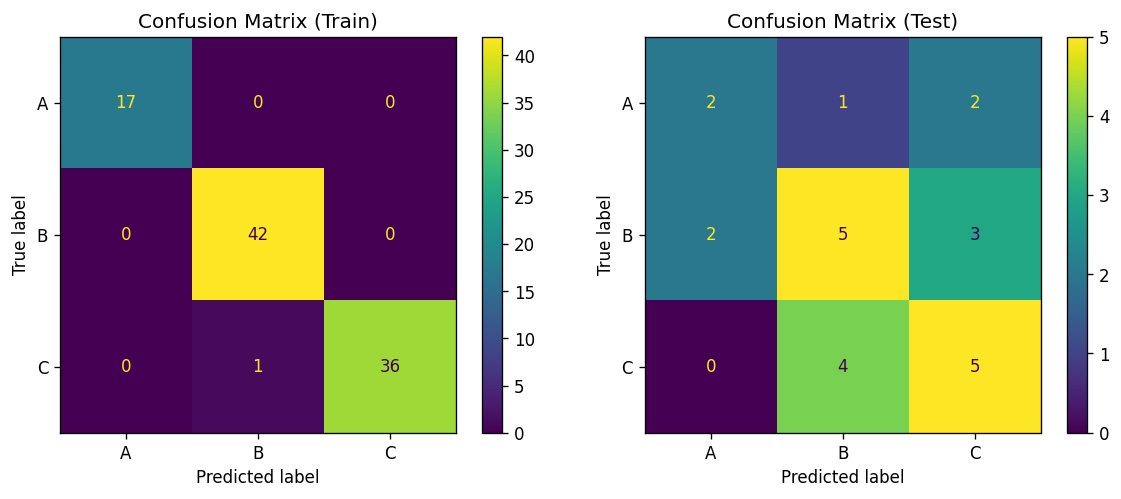

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        17
           B       0.98      1.00      0.99        42
           C       1.00      0.97      0.99        37

    accuracy                           0.99        96
   macro avg       0.99      0.99      0.99        96
weighted avg       0.99      0.99      0.99        96

Test:
               precision    recall  f1-score   support

           A       0.50      0.40      0.44         5
           B       0.50      0.50      0.50        10
           C       0.50      0.56      0.53         9

    accuracy                           0.50        24
   macro avg       0.50      0.49      0.49        24
weighted avg       0.50      0.50      0.50        24

---------------------------------------------------------

---------------------------------------------------------

GaussianNaiveBayes



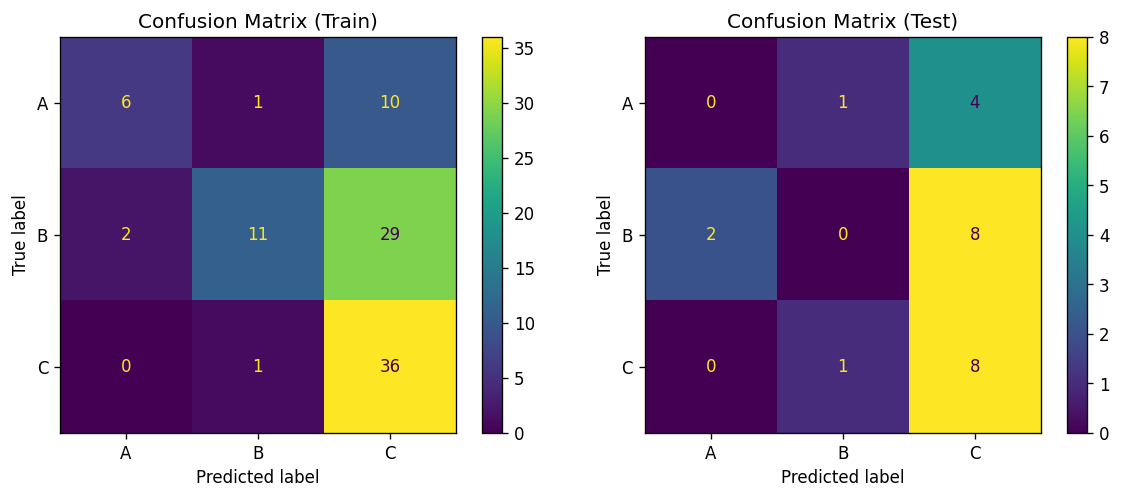

Train:
               precision    recall  f1-score   support

           A       0.75      0.35      0.48        17
           B       0.85      0.26      0.40        42
           C       0.48      0.97      0.64        37

    accuracy                           0.55        96
   macro avg       0.69      0.53      0.51        96
weighted avg       0.69      0.55      0.51        96

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         5
           B       0.00      0.00      0.00        10
           C       0.40      0.89      0.55         9

    accuracy                           0.33        24
   macro avg       0.13      0.30      0.18        24
weighted avg       0.15      0.33      0.21        24

---------------------------------------------------------

---------------------------------------------------------

SupportVectorMachine



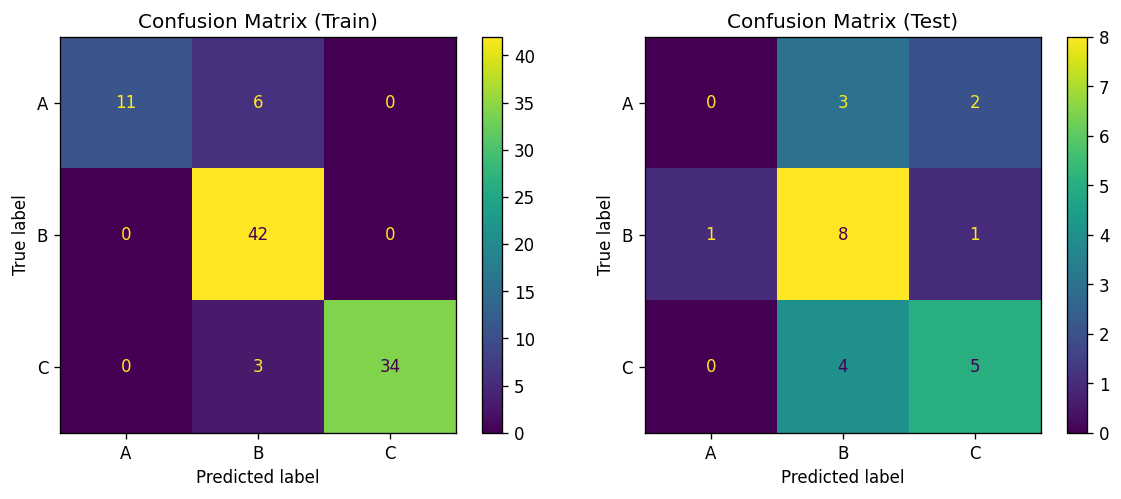

Train:
               precision    recall  f1-score   support

           A       1.00      0.65      0.79        17
           B       0.82      1.00      0.90        42
           C       1.00      0.92      0.96        37

    accuracy                           0.91        96
   macro avg       0.94      0.86      0.88        96
weighted avg       0.92      0.91      0.90        96

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         5
           B       0.53      0.80      0.64        10
           C       0.62      0.56      0.59         9

    accuracy                           0.54        24
   macro avg       0.39      0.45      0.41        24
weighted avg       0.46      0.54      0.49        24

---------------------------------------------------------

---------------------------------------------------------

KNeighborsClassifier



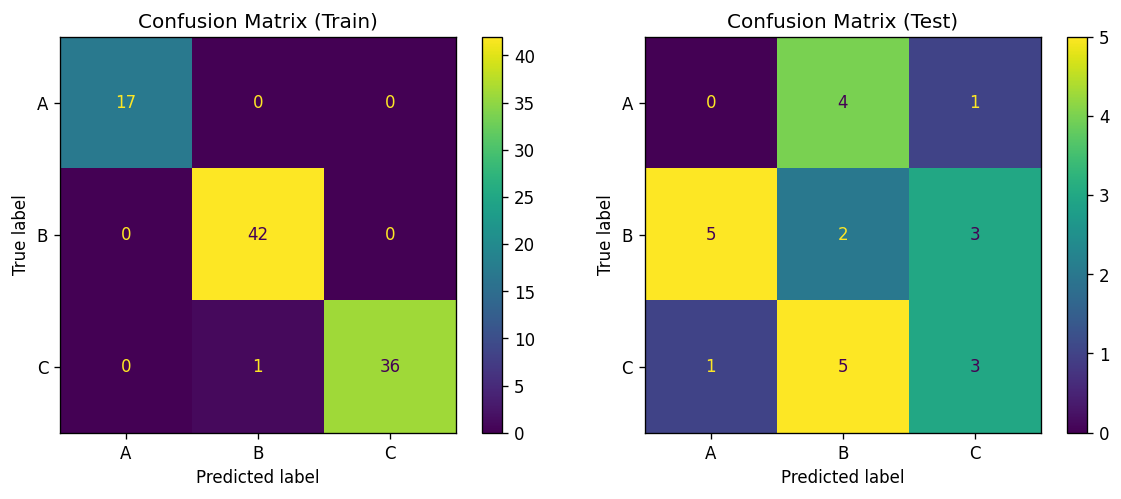

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        17
           B       0.98      1.00      0.99        42
           C       1.00      0.97      0.99        37

    accuracy                           0.99        96
   macro avg       0.99      0.99      0.99        96
weighted avg       0.99      0.99      0.99        96

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         5
           B       0.18      0.20      0.19        10
           C       0.43      0.33      0.38         9

    accuracy                           0.21        24
   macro avg       0.20      0.18      0.19        24
weighted avg       0.24      0.21      0.22        24

---------------------------------------------------------

---------------------------------------------------------

DecisionTreeClassifier



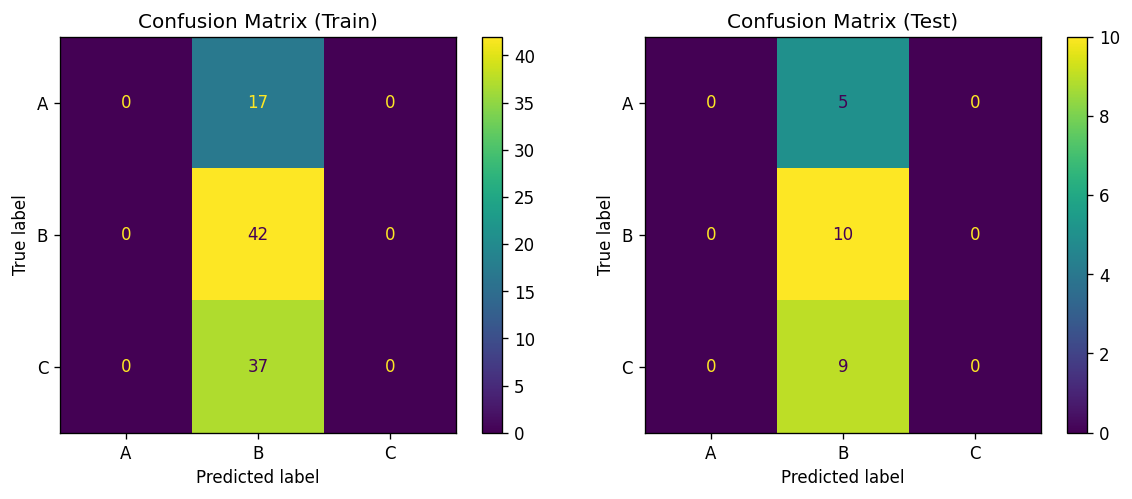

Train:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00        17
           B       0.44      1.00      0.61        42
           C       0.00      0.00      0.00        37

    accuracy                           0.44        96
   macro avg       0.15      0.33      0.20        96
weighted avg       0.19      0.44      0.27        96

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         5
           B       0.42      1.00      0.59        10
           C       0.00      0.00      0.00         9

    accuracy                           0.42        24
   macro avg       0.14      0.33      0.20        24
weighted avg       0.17      0.42      0.25        24

---------------------------------------------------------

---------------------------------------------------------

RandomForestClassifier



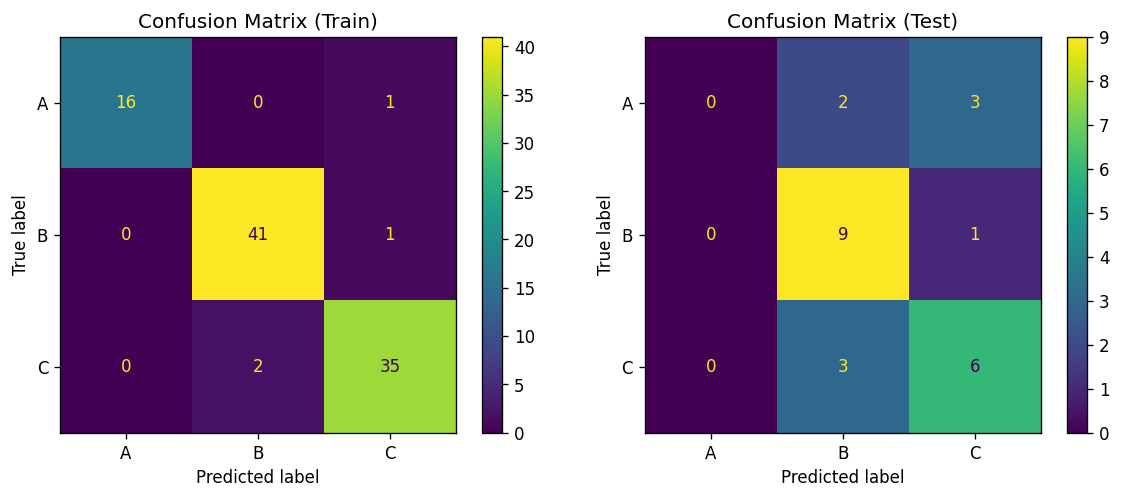

Train:
               precision    recall  f1-score   support

           A       1.00      0.94      0.97        17
           B       0.95      0.98      0.96        42
           C       0.95      0.95      0.95        37

    accuracy                           0.96        96
   macro avg       0.97      0.95      0.96        96
weighted avg       0.96      0.96      0.96        96

Test:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00         5
           B       0.64      0.90      0.75        10
           C       0.60      0.67      0.63         9

    accuracy                           0.62        24
   macro avg       0.41      0.52      0.46        24
weighted avg       0.49      0.62      0.55        24

---------------------------------------------------------

---------------------------------------------------------

GradientBoostingClassifier



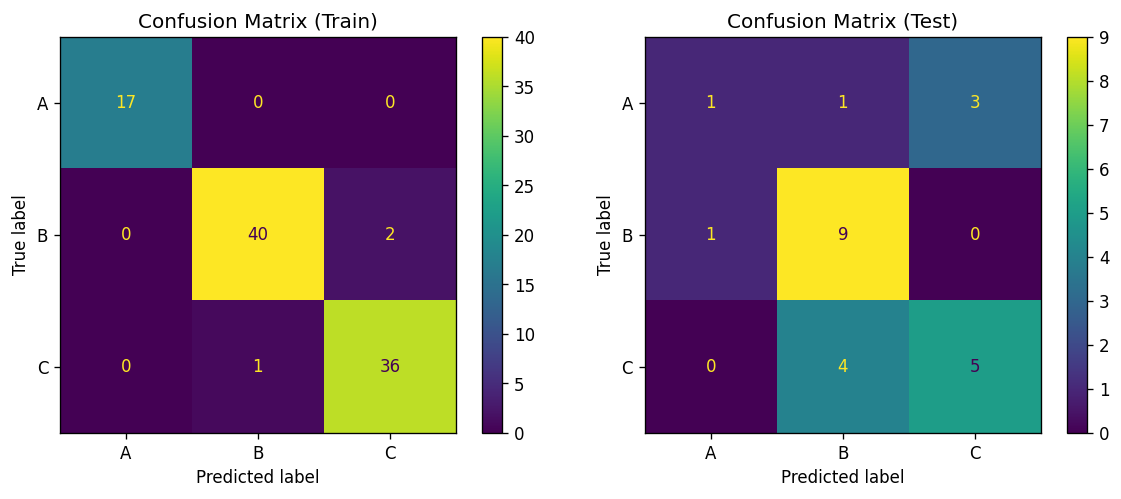

Train:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        17
           B       0.98      0.95      0.96        42
           C       0.95      0.97      0.96        37

    accuracy                           0.97        96
   macro avg       0.97      0.98      0.97        96
weighted avg       0.97      0.97      0.97        96

Test:
               precision    recall  f1-score   support

           A       0.50      0.20      0.29         5
           B       0.64      0.90      0.75        10
           C       0.62      0.56      0.59         9

    accuracy                           0.62        24
   macro avg       0.59      0.55      0.54        24
weighted avg       0.61      0.62      0.59        24

---------------------------------------------------------

---------------------------------------------------------

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
Y

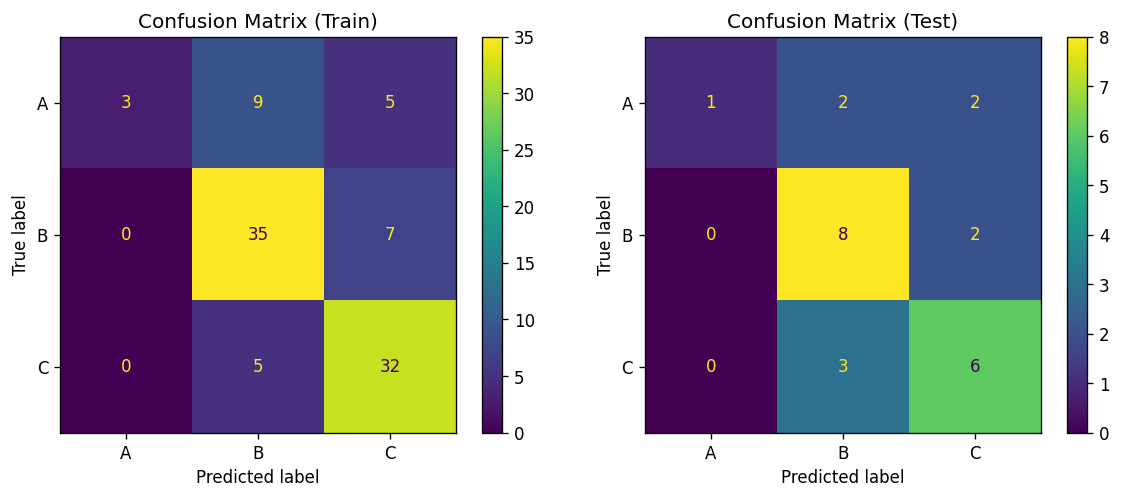

Train:
               precision    recall  f1-score   support

           A       1.00      0.18      0.30        17
           B       0.71      0.83      0.77        42
           C       0.73      0.86      0.79        37

    accuracy                           0.73        96
   macro avg       0.81      0.62      0.62        96
weighted avg       0.77      0.73      0.69        96

Test:
               precision    recall  f1-score   support

           A       1.00      0.20      0.33         5
           B       0.62      0.80      0.70        10
           C       0.60      0.67      0.63         9

    accuracy                           0.62        24
   macro avg       0.74      0.56      0.55        24
weighted avg       0.69      0.62      0.60        24

---------------------------------------------------------

---------------------------------------------------------

XGBoost



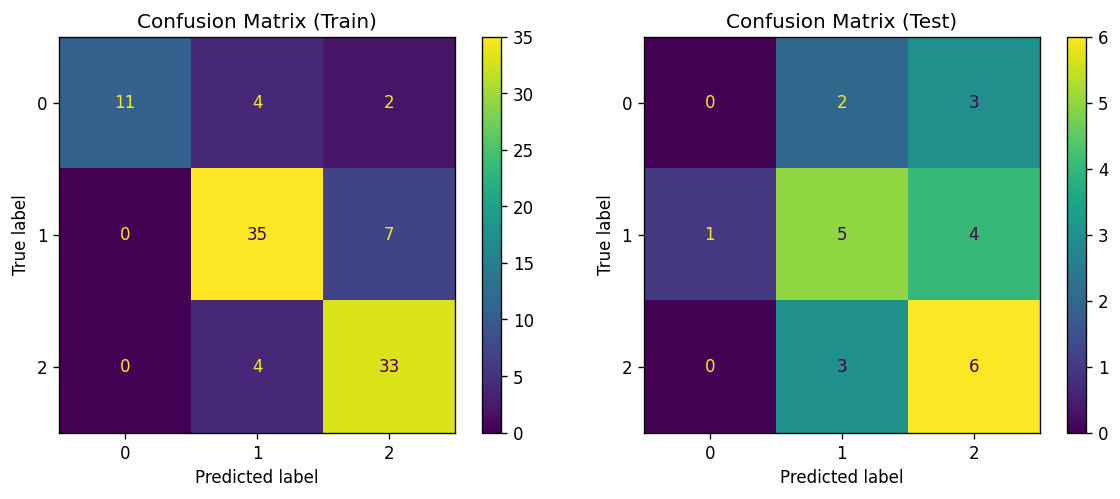

Train:
               precision    recall  f1-score   support

           0       1.00      0.65      0.79        17
           1       0.81      0.83      0.82        42
           2       0.79      0.89      0.84        37

    accuracy                           0.82        96
   macro avg       0.87      0.79      0.81        96
weighted avg       0.84      0.82      0.82        96

Test:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.50      0.50      0.50        10
           2       0.46      0.67      0.55         9

    accuracy                           0.46        24
   macro avg       0.32      0.39      0.35        24
weighted avg       0.38      0.46      0.41        24

---------------------------------------------------------

---------------------------------------------------------



,Model,Prediction Sample,ROC-AUC,Accuracy,Precision,Recall,F1
0,LogisticRegression,Train,0.99945,0.98958,0.98983,0.98958,0.98957
1,LogisticRegression,Test,0.63485,0.50000,0.50000,0.50000,0.49829
2,GaussianNaiveBayes,Train,0.85149,0.55208,0.68800,0.55208,0.50777
3,GaussianNaiveBayes,Test,0.55605,0.33333,0.15000,0.33333,0.20690
4,SupportVectorMachine,Train,0.78918,0.90625,0.92279,0.90625,0.90343
5,SupportVectorMachine,Test,0.66113,0.54167,0.45660,0.54167,0.48725
6,KNeighborsClassifier,Train,0.99945,0.98958,0.98983,0.98958,0.98957
7,KNeighborsClassifier,Test,0.48126,0.20833,0.23647,0.20833,0.21999
8,DecisionTreeClassifier,Train,0.60148,0.43750,0.19141,0.43750,0.26630
9,DecisionTreeClassifier,Test,0.52754,0.41667,0.17361,0.41667,0.24510


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 50
[LightGBM] [Info] Start training from score -1.731135
[LightGBM] [Info] Start training from score -0.826679
[LightGBM] [Info] Start training from score -0.953430


,company,G_Rating_band,Prediction(G_Rating_band),Probability(G_Rating_band)=A,Probability(G_Rating_band)=B,Probability(G_Rating_band)=C
0,"""Соликамскбумпром""",B,C,0.086410,0.330273,0.583317
1,«Вкусвилл»,C,B,0.346477,0.431431,0.222092
2,«Группа ПОЛИПЛАСТИК»,C,B,0.220578,0.553170,0.226252
3,«Группа Черкизово»,B,B,0.248183,0.376288,0.375528
4,«Лента» (сеть гипермаркетов),B,B,0.194992,0.421622,0.383385
5,"«М.Видео-Эльдорадо», группа",B,B,0.191564,0.514806,0.293630
6,«Новая горная управляющая компания»,C,C,0.257224,0.243793,0.498983
7,«Новороссийский морской торговый порт»,C,C,0.056694,0.368716,0.574590
8,"«Норильский никель», горно-металлургическая ко...",A,C,0.217439,0.290936,0.491625
9,«Полиметалл»,A,B,0.260534,0.554713,0.184754


Best model is LightGBM

---------------------------------------------------------



,Model,Prediction Sample,ROC-AUC,Accuracy,Precision,Recall,F1
0,LightGBM,Test,0.72506,0.625,0.68974,0.625,0.59614


In [ ]:
#final_res = rating_band_prediction(features_data, target, best_models, test_data)
rating_band_prediction(features_data, target)